# Preliminaries
Apart from M5 accuracy dataset this notebook uses a dataset created for quick WRMSE calculation. It can be found in the output of the https://www.kaggle.com/sibmike/fast-clear-wrmsse-18ms/#data notebook and the approach is explained there as well. Eventually we only integrated it to evaluate the prediction on validation set wihout making a submission. It was important for us, because we did not have much time left before the deadline when we managed to make a basic LSTM model work.

In [1]:
import os
import random
import numpy as np
from numpy import hstack
import pandas as pd
import time 
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from itertools import cycle
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import csr_matrix
from tensorflow import keras
from keras.optimizers import Adam
from keras.utils import plot_model, Sequence
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Dropout
%matplotlib inline

Using TensorFlow backend.


## Pandas and pyplot display options set up

In [2]:
# Set up Bayesian Methods for Hackers matplotlib style
plt.style.use('bmh')

# Set up custom color palette/optional
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# Load data and reduce memory usage
**The "reduce_mem_usage" function below is taken from this kernel** https://www.kaggle.com/kyakovlev/m5-simple-fe 

In [3]:
"""
Reduces memory ocuppied by a dataframe by transfroming column type to the smallest type 
with capacity enough to store the column content
Parameters:
    df - a dataframe to reduce memory usage
    verbose - a boolen flag which indicates if infromation about memory reduction is printed
Returns:
    A data frame transformed to use as little memory as possible
"""
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
"""
Creates dataframes with reduced memory usage from competition .csv files 
Parameters:
    input_dir - a path to M5 dataset
    verbose - a boolen flag which indicates if infromation about memory reduction is printed
Returns:
    sell_prices_df - a dataframe containing sell_prices.csv data
    calendar_df - a dataframe containing calendar.csv data
    sales_train_evaluation_df - a dataframe containing sales_train_evaluation.csv data
    sample_submission - a dataframe containing sample_submission.csv data
"""
def read_data(input_dir):
    sell_prices_df = reduce_mem_usage(pd.read_csv(input_dir + 'sell_prices.csv'))
    print('Sell prices has {} rows and {} columns'.format(sell_prices_df.shape[0], sell_prices_df.shape[1]))

    calendar_df = pd.read_csv(input_dir + 'calendar.csv')
    # Cast string representation of data to datetime
    # it will simplify creation of calendar features
    calendar_df["date"] = pd.to_datetime(calendar_df["date"])
    calendar_df = reduce_mem_usage(calendar_df)
    print('Calendar has {} rows and {} columns'.format(calendar_df.shape[0], calendar_df.shape[1]))
    
    # Initially sales_train_validation.csv was used here, but after validation data was released we switched to sales_train_evaluation.csv
    # to simplify comparison of model prediction to ground truth validation data
    sales_train_evaluation_df = reduce_mem_usage(pd.read_csv(input_dir + 'sales_train_evaluation.csv'))
    print('Sales train validation has {} rows and {} columns'.format(sales_train_evaluation_df.shape[0], sales_train_evaluation_df.shape[1]))

    submission_df = reduce_mem_usage(pd.read_csv(input_dir + 'sample_submission.csv'))
    return sell_prices_df, calendar_df, sales_train_evaluation_df, submission_df

"""
Creates a data frame for items sales per day with item ids as columns names and dates as the index  
Parameters:
    calendar_df - a dataframe containing calendar.csv data with 'date' in datetime format
    sales_train_evaluation_df - a dataframe containing sales_train_evaluation.csv data
Returns:
    A dataframe containing sales for training and validation days
    rows represent days and column a unique item id
    index is set to dates in datetime format
"""
def create_sales_df(calendar_df, sales_train_evaluation_df):
    # Create a unique item id from 'item_id' and 'store_id'
    sales_train_evaluation_df['item_store_id'] = sales_train_evaluation_df.apply(
        lambda x: x['item_id'] + '_' + x['store_id'], axis=1)
    # Extract training and validation days
    DF_Sales = sales_train_evaluation_df.loc[:, 'd_1':'d_1941'].T
    # Set unique item ids as columns
    DF_Sales.columns = sales_train_evaluation_df['item_store_id'].values
    
    # Set dates as index
    date_index = calendar_df['date']
    dates = date_index[0:1941].values
    DF_Sales = DF_Sales.set_index([dates])
    DF_Sales.index = pd.to_datetime(DF_Sales.index)
    return DF_Sales

In [5]:
# Competition dataset
INPUT_DIR_PATH = '../input/m5-forecasting-accuracy/'
# WRMSE calculation dataset
INPUT_DIR_PATH_WRMSE = '../input/m5-accuracy-wrmse/'

In [6]:
# Load calendar and sales data
_,  calendar_df, sales_train_evaluation_df, _ = read_data(INPUT_DIR_PATH)

Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 96.13 Mb (78.8% reduction)
Sales train validation has 30490 rows and 1947 columns
Mem. usage decreased to  2.09 Mb (84.5% reduction)


In [7]:
# Create sales dataframe containing training and validation data
DF_Sales = create_sales_df(calendar_df, sales_train_evaluation_df)
# Split the dataframe into training and validation data
# We need to make a prediction for 28 days
forecast_horizon = 28
DF_Sales_Train = DF_Sales.iloc[:-forecast_horizon,:]
DF_Sales_Val = DF_Sales.iloc[-forecast_horizon:,:]

# Calendar features extraction

In [8]:
"""
Creates a data frame with calendar features
Parameters:
    calendar_df - a dataframe containing calendar.csv data with 'date' in datetime format
Returns:
    A dataframe containing features:  
        event_name_1_cat - a categorical feature which denotes a type of an event
        snap_CA - a boolean feature which denotes if it is a snap day in CA
        snap_TX - a boolean feature which denotes if it is a snap day in TX
        snap_WI - a boolean feature which denotes if it is a snap day in WI
        wday - a categorical feature which denotes a day of week
        week - a categorical feature which denotes a number of week
        month - a categorical feature which denotes a month
        mday - a categorical feature which denotes a day number in a month
"""
def create_features(calendar_df):
    cal_features_columns = ["date", "event_name_1", "snap_CA", "snap_TX", "snap_WI"]
    cal_features = calendar_df[cal_features_columns].fillna(0)
    cal_features["event_name_1"] = cal_features["event_name_1"].astype('category')
    cal_features["event_name_1_cat"] = cal_features["event_name_1"].cat.codes
    del cal_features["event_name_1"]
    
    date_features = {
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "mday": "day",
    }

    for date_feat_name, date_feat_func in date_features.items():
        cal_features[date_feat_name] = getattr(cal_features["date"].dt, date_feat_func).astype("int16")
    
    del cal_features["date"]
    
    return cal_features

In [9]:
# Extract features from calendar dataframe
cal_features = create_features(calendar_df)
# Split features into training a validation dataframes
# The validation data dataframe will be used for features extraction during prediction
cal_train = cal_features.iloc[:-forecast_horizon * 2,:]
cal_val = cal_features.iloc[-forecast_horizon * 2:,:]

# Prepare the data for training

In [10]:
"""
Extracts a subset of data for training  
Parameters:
    data - a dataframe containing sales data in which rows represent days and columns - unique items
    num_days_included - how many days to include into training set
Returns:
    A numpy array containing num_days_included last days from the dataset
"""
def train_subset(data, num_days_included=365):
    all_data = np.array(data)
    data_subset = all_data[-num_days_included:, :]
    return data_subset

In [11]:
"""
Applies MinMaxScaler on the data 
Parameters:
    data - a numpy array containing sales data in which rows represent days and columns - unique items
    scaler - a MinMaxScaler instance
    plot - a boolean flag which indicates if we want to plot data distribution before and after scaling
Returns:
    A numpy array scaled by scaler
"""
def scaled_data(data, scaler, plot=False):
    train_data_normalized = scaler.fit_transform(data)

    if plot:
        # we check that data distribution did not change after normalization
        fig, axs = plt.subplots(2)
        fig.suptitle('Data Distribution Before and After Normalization ', fontsize=19)
        pd.DataFrame(data).plot(kind='hist', ax=axs[0], alpha=.4, figsize=[12, 6], legend=False,
                                title=' Before Normalization', color='red')
        pd.DataFrame(train_data_normalized).plot(kind='hist', ax=axs[1], figsize=[12, 6], alpha=.4, legend=False,
                                                 title=' After Normalization' \
                                                 , color='blue')

    return train_data_normalized

In [12]:
"""
Splits the data into training and validation sets
Parameters:
    dataset - a numpy array containing sales data in which rows represent days and columns - unique items
    validation_size - how many days to include into validation dataset
Returns:
    A tuple (train_data, val_data)
    train_data - data to be used for model training
    val_data - data to be used for validation. None if validation_size=0
"""
def train_val_split(dataset, validation_size=0):
    if validation_size > 0:
        train_size = len(dataset[:,0]) - validation_size

        train = dataset[:train_size]
        val = dataset[train_size:]
        return train, val
    else:
        return dataset, None

In [13]:
# Get the subset used for training
data = train_subset(DF_Sales_Train, 1913)
# Normalize to impove NN training
scaler = MinMaxScaler()
normalized_data = scaled_data(data, scaler)
# Split the training set into training and validation parts
# validation_data were used in early stage of model development, 
# now we use the whole training set to fit the model
train_data, validation_data = train_val_split(normalized_data, 0)
# Scale calendar features
cal_data_train = cal_train.values
scaler_cal = MinMaxScaler()
normalized_cal = scaler_cal.fit_transform(cal_data_train)

# LSTM Model

In [14]:
"""
Builds LTSM neural network
Parameters:
    input_shape - a tuple in which the first item is a sequence length
                  and the second one is a number of features
    output_num - a number of sequences to predict
Returns:
    A Sequential LSTM model 
"""
def LSTM_model(input_shape, output_num):
    model = Sequential()

    # Adding the first LSTM layer and some dropout
    layer1_units_num = 50
    model.add(LSTM(units=layer1_units_num, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))

    # Adding a second LSTM layer and dropout
    layer2_units_num = 300
    model.add(LSTM(units=layer2_units_num, return_sequences=True))
    model.add(Dropout(0.2))
    
    # Adding a third LSTM layer and dropout
    layer3_units_num = 300
    model.add(LSTM(units=layer3_units_num))
    model.add(Dropout(0.2))

    # Adding the output layer for prediction
    model.add(Dense(units = output_num))
    return model

In [15]:
seq_length = 28
# We add calendar features to sales data to train the model, thus number of features is sum
# of time series number and number of calendar features
features_number = train_data.shape[1] + normalized_cal.shape[1]
lstm = LSTM_model((seq_length, features_number), 30490)
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 28, 50)            6109800   
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 28, 300)           421200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 300)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dropout_3 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 30490)            

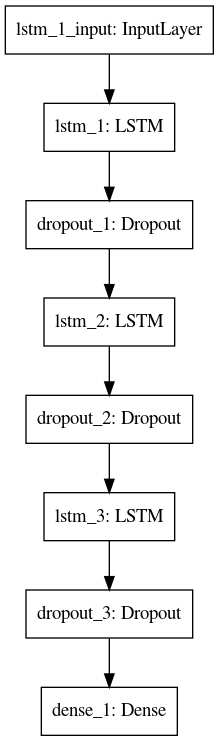

In [16]:
plot_model(lstm, to_file='lstm.png')

# Data generator

In [17]:
"""
Data generator of training sequences and labels for LSTM
"""
class SlidingWindowDataGenerator(Sequence):
    """
    Parameters:
        timeseries - a numpy array with sales data (rows denote days and columns - products)
        calendar - a numpy array with calendar features (rows denote days and columns - features)
        train_seq_len - a length of training sequences
        batch_size - a batch size
        shuffle - a boolean flag which denotes if data is shuffled
    """
    def __init__(self, timeseries, calendar, train_seq_len=28, batch_size=32, shuffle=True):
        self.timeseries = timeseries
        self.calendar = calendar
        self.train_seq_len = train_seq_len
        self.batch_size = batch_size
        # Generally if we want to extract sequences with sliding window, the number of sequences
        # = time series steps number - length of training sequence + 1
        # however we also need 1 time step data as labes
        self.seq_num = len(self.timeseries) - self.train_seq_len
        self.shuffle = shuffle
        self.on_epoch_end()
        self.n = 0
        self.max = self.__len__()
        
    """
    Calculates the length of an object
    Returns:
        A number of batches per epoch
    """
    def __len__(self):
        
        return int(np.floor(self.seq_num / self.batch_size))
    
    """
    Returns a next batch of sequences
    Returns:
        A next batch. Useful for object debuging
    """
    def __next__(self):
        if self.n >= self.max:
            self.n = 0
        result = self.__getitem__(self.n)
        self.n += 1
        return result

    """
    Returns a batch of sequences at the specified index
    Parameters:
        index - an index of the requested batch
    Returns:
        A tuple of numpy arrays in which the first array contains a batch of training sequences
        with shape [batch_size, sequence_len, features]
        and the second array contains a batch of the corresponding labels
        with shape [batch_size, output_labels]
    """
    def __getitem__(self, index):
        # Since indexes might be shuffled we need to obtain a set of shuffled indexes 
        # wich correspond to the specified index
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        x, y = [], []
        for i in indexes:
            # Extract sales data
            x_next = self.timeseries[i:i+self.train_seq_len, :]
            # Extract calendar features
            calendar_next = self.calendar[i:i+self.train_seq_len, :]
            # Join sales data and calendar features and add it to a batch of training data
            x.append(hstack((x_next, calendar_next)))
            # Add next time steps to a batch of labels
            y_next = self.timeseries[i + self.train_seq_len, :]
            y.append(y_next)
        return np.array(x), np.array(y)
    
    """
    Shuffles indexes after each epoch if shuffle=True
    """
    def on_epoch_end(self):
        
        self.indexes = np.arange(self.seq_num)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

# Traning of LSTM

In [18]:
# Compile the model with standart Adam optimizer
lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

batch_size = 32
# Data generation for training
data_gen_train = SlidingWindowDataGenerator(train_data, normalized_cal, train_seq_len=seq_length, batch_size=batch_size)
# Data generation for validation. Only defined if validation_data is not None
data_gen_validation = SlidingWindowDataGenerator(validation_data, normalized_cal, train_seq_len=seq_length, batch_size=1) if validation_data is not None else None

# Fit LSTM model to data
history = lstm.fit_generator(data_gen_train,
                            epochs = 32, 
                            validation_data = data_gen_validation, 
                            steps_per_epoch= int(np.floor((len(train_data) - seq_length) / batch_size)))

Epoch 1/32
58/58 [==============================] - 26s 450ms/step - loss: 0.0153
Epoch 2/32
58/58 [==============================] - 24s 419ms/step - loss: 0.0135
Epoch 3/32
58/58 [==============================] - 25s 437ms/step - loss: 0.0132
Epoch 4/32
58/58 [==============================] - 24s 417ms/step - loss: 0.0129
Epoch 5/32
58/58 [==============================] - 24s 415ms/step - loss: 0.0127
Epoch 6/32
58/58 [==============================] - 25s 435ms/step - loss: 0.0126
Epoch 7/32
58/58 [==============================] - 24s 416ms/step - loss: 0.0124
Epoch 8/32
58/58 [==============================] - 25s 428ms/step - loss: 0.0124
Epoch 9/32
58/58 [==============================] - 24s 417ms/step - loss: 0.0122
Epoch 10/32
58/58 [==============================] - 25s 427ms/step - loss: 0.0121
Epoch 11/32
58/58 [==============================] - 25s 428ms/step - loss: 0.0120
Epoch 12/32
58/58 [==============================] - 24s 418ms/step - loss: 0.0119
Epoch 13/32
5

# Prediction

In [19]:
"""
Performs a prediction for validation and evaluation data
Parameters:
    lstm - a trained lstm model
    sequence_for_prediction - a sequence right befor the first validation day
    calendar - normalized calendar features for validation set
    scaler - a MinMaxScaler used to normalise sales data
    prediction_window - how many validation and evaluation days
    seq_length - a length of a sequence used in the model
Returns:
    A dataframe containing a prediction in which rows denote a day and column denote indexes of products.
    Note that to match submission format same products for validation and evaluation sales 
    have different indexes. Thus shape of an array is 28x60980, not 56x30490
"""
def predict(lstm, sequence_for_prediction, calendar, scaler, prediction_window = 28, seq_length=28):
    prediction_val = []
    prediction_eval = []
    
    # Prediction for validation period
    for i in range(0, prediction_window):
        # Predict sales for the next day
        prediction = lstm.predict(sequence_for_prediction)
        prediction_val.append(prediction[0])
        # Merge predicted sales and calendar features into last training sequence
        next_seq = np.array([hstack((prediction[0], calendar[i]))])
        # Add next sequence to the end of training sequences and drop the first one
        sequence_for_prediction[0] = np.concatenate((sequence_for_prediction[0], next_seq), axis=0)[-seq_length:, :]

    # Prediction for evaluation period
    for i in range(0, prediction_window):
        # Predict sales for the next day
        prediction = lstm.predict(sequence_for_prediction)
        prediction_eval.append(prediction[0])
        # Merge predicted sales and calendar features into last training sequence
        next_seq = np.array([hstack((prediction[0], calendar[prediction_window + i]))])
        # Add next sequence to the end of training sequences and drop the first one
        sequence_for_prediction[0] = np.concatenate((sequence_for_prediction[0], next_seq), axis=0)[-seq_length:, :]
        
    prediction_val = np.array(prediction_val)
    prediction_eval = np.array(prediction_eval)

    # Inverse normalize predictions
    prediction_transformed_val = scaler.inverse_transform(prediction_val)
    prediction_transformed_eval = scaler.inverse_transform(prediction_eval)
    
    # Merge validation and evaluation predictions
    predictions = hstack((prediction_transformed_val, prediction_transformed_eval))
    # NN often gives small negative output. This prediction is invalid, so we set all negative values to 0
    predictions[predictions < 0] = 0

    # create data frames
    df_prediction = pd.DataFrame(predictions)
    return df_prediction
    

In [20]:
# Scale calendar features for the validation set
cal_val_scaled = scaler_cal.transform(cal_val.values)
# Extract the sequence to predict the first validation day sales
sequence_for_prediction = np.array([hstack((train_data[-seq_length:, :], cal_data_train[-seq_length:, :]))])
# Predict sales and save it to dataframe
df_prediction = predict(lstm, sequence_for_prediction, cal_val_scaled, scaler, 28, seq_length)

# Demonstration of prediction on validation set

In [21]:
"""
Plots a prediction and groud truth for a randomly selected product
if groud truth is not specified plots only prediction
Parameters:
    df_predict - a numpy array with prediction (rows denote days and columns - products)
    df_labels - a numpy array with ground truth (rows denote days and columns - products)
"""
def plot_random_prediction(prediction, labels=None):
    # Plot prediction
    figure(num=None, figsize=(19, 6), dpi=80, facecolor='w', edgecolor='k') 
    index = random.randint(0, prediction.shape[1]-1)
    plt.plot(prediction[:, index])
    # If labels are present plot ground truth
    if labels is not None:
        plt.plot(labels[:, index])
        plt.legend(['Prediction','Time Series'],fontsize = 21)
    else:
        plt.legend(['Prediction'],fontsize = 21)
    plt.suptitle('Time-Series Prediction Test Set',fontsize = 23)
    plt.xticks(fontsize=21)
    plt.yticks(fontsize=21)
    plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
    plt.xlabel(xlabel = 'Date',fontsize = 21)
    plt.show()

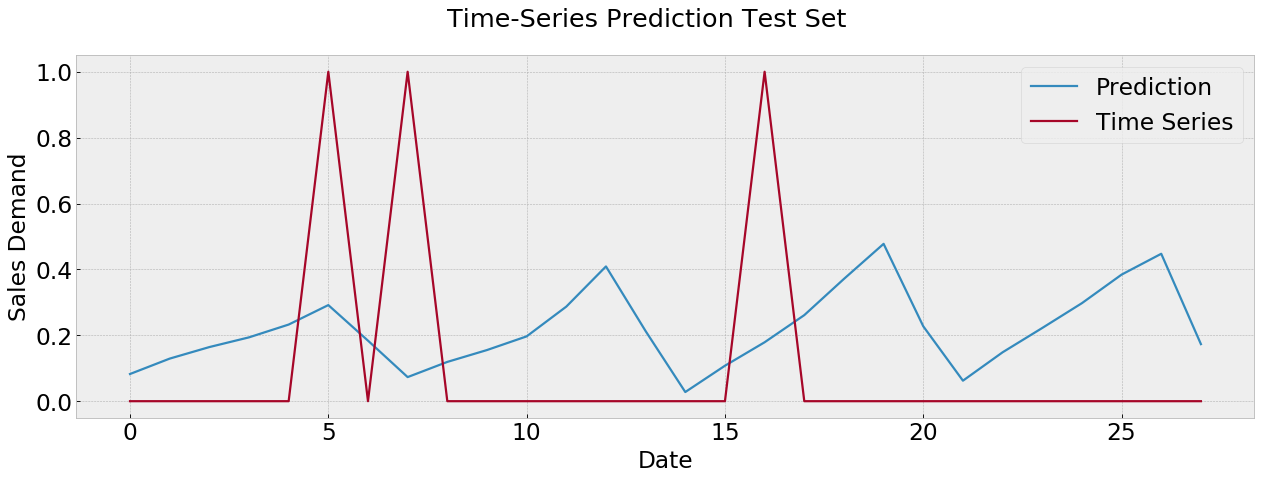

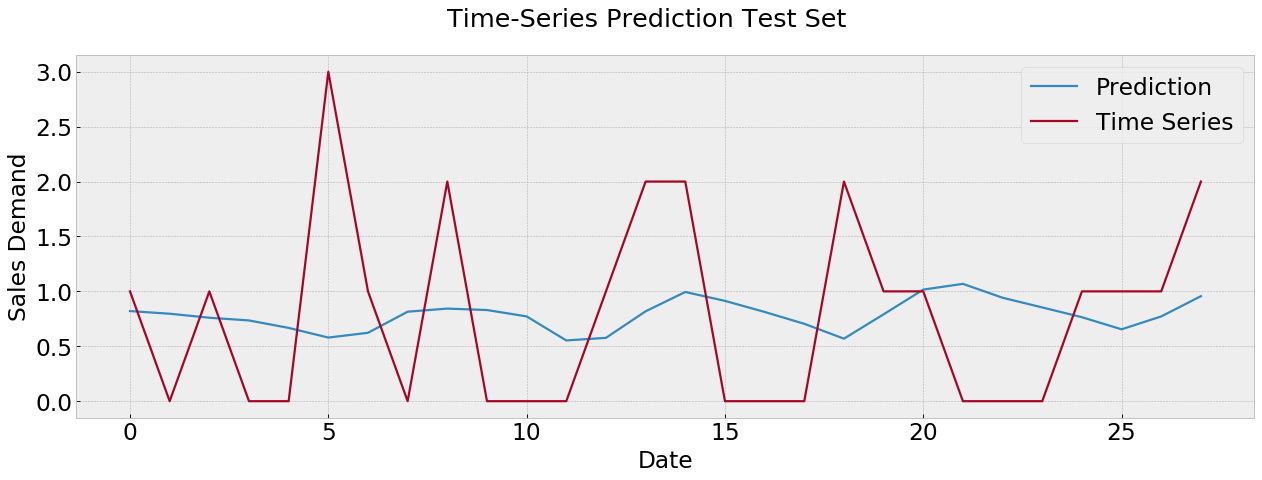

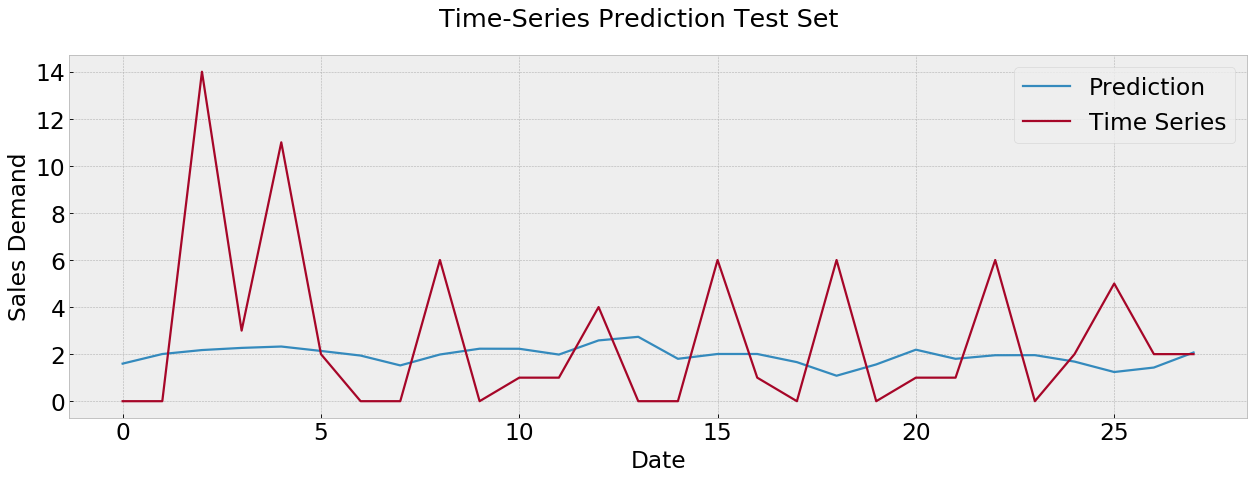

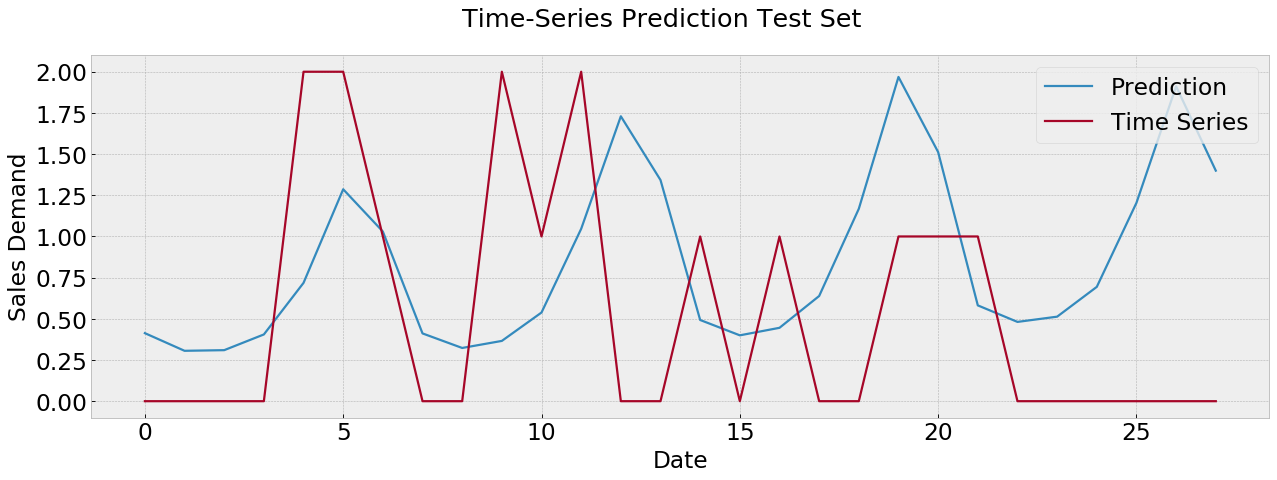

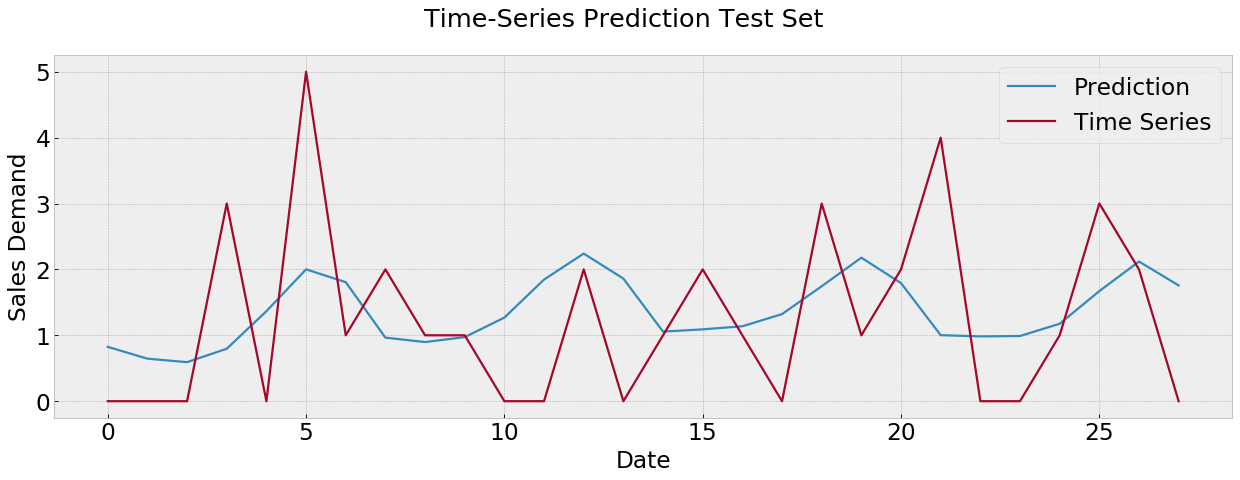

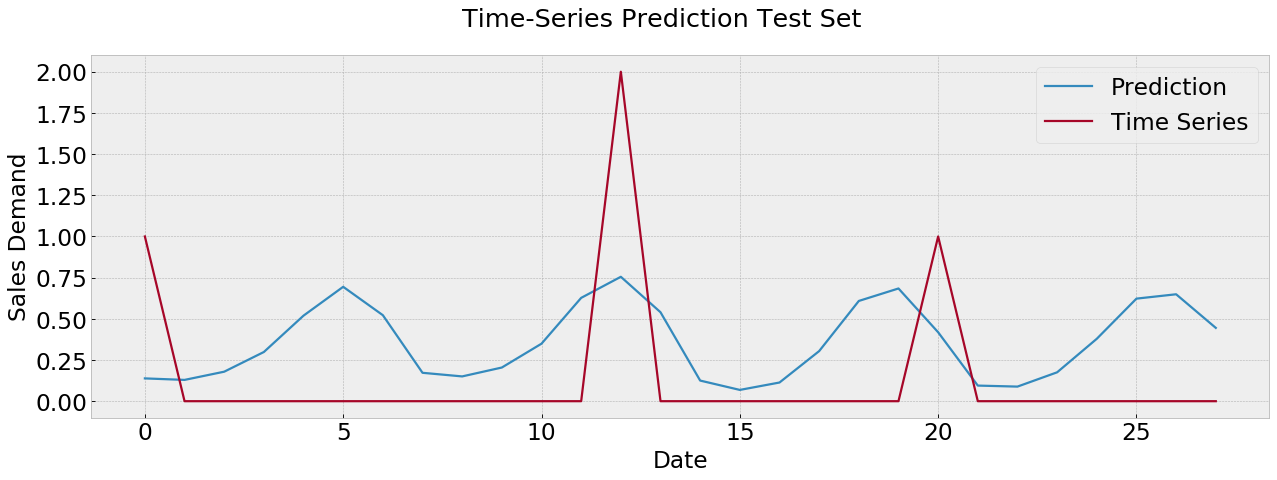

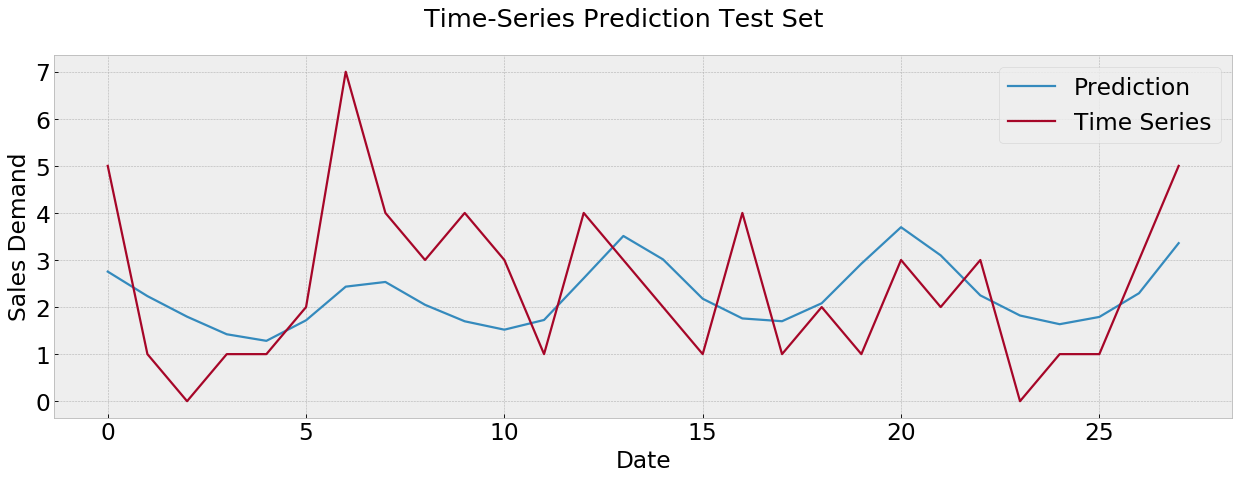

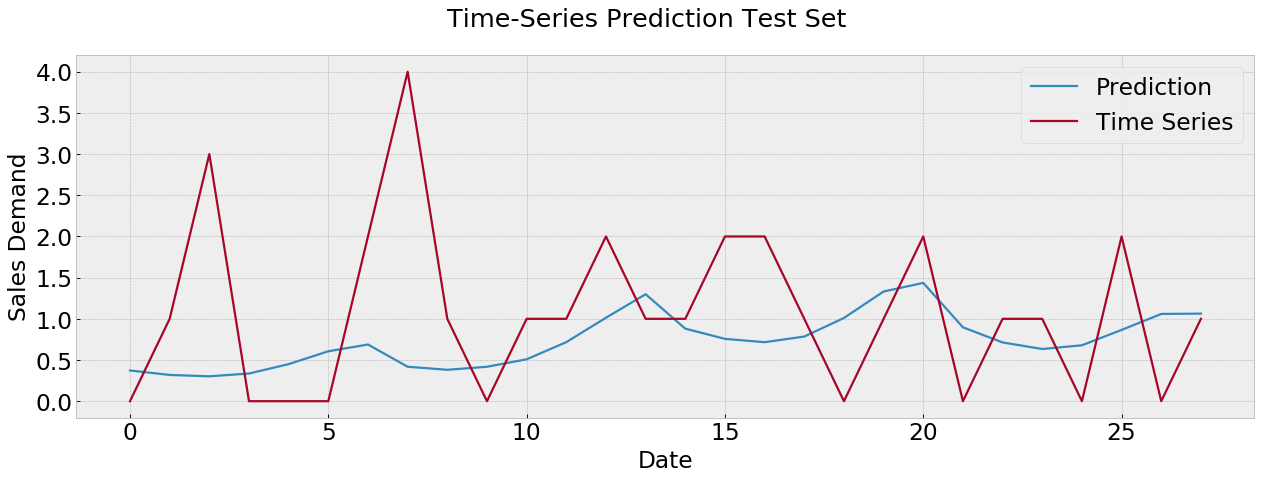

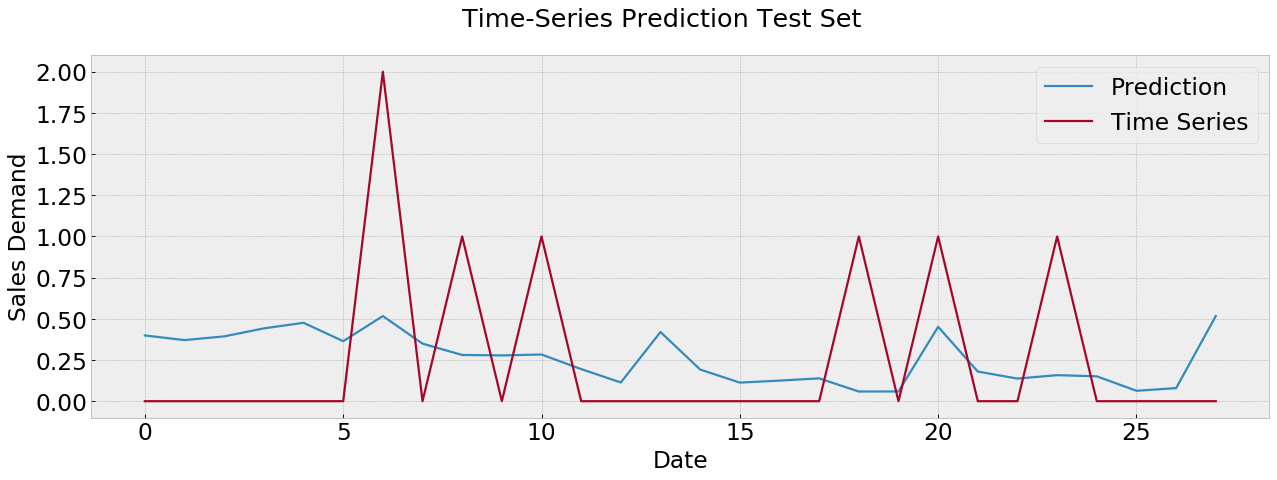

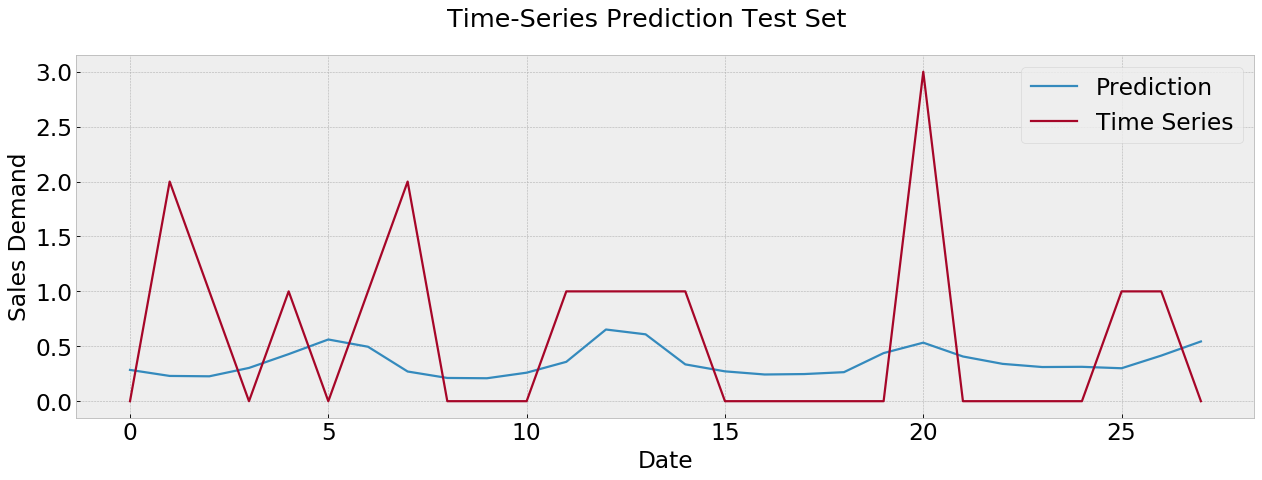

In [22]:
# Plot prediction for a few series
# Extract prediction for validation days
prediction_val = np.array(df_prediction)[:, :30490]
labels_val = np.array(DF_Sales_Val)
for i in range(0, 10):
    plot_random_prediction(prediction_val, labels_val)

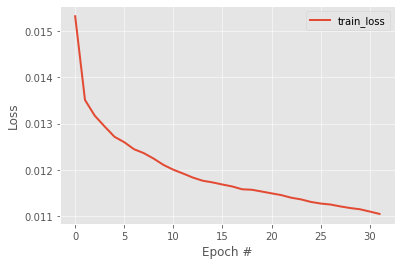

In [23]:
# Plot training loss
plt.style.use('ggplot')
plt.figure()
epoch = len(history.history['loss'])
plt.plot(np.arange(0, epoch), history.history['loss'], label='train_loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Creation of submission file

In [24]:
"""
Plots saves prediction to .csv file in competition submission format
if groud truth is not specified plots only prediction
Parameters:
    df_prediction - a dataframe with prediction (rows denote days and columns - validation and evaluation products)
    df_sales - a dataframe with sales data
"""
def create_submission(df_prediction, df_sales):
    # Create columns names based on items ids in sales dataframe
    columns_val = [c+"_validation" for c in df_sales.columns]
    columns_eval = [c+"_evaluation" for c in df_sales.columns]
    columns = columns_val + columns_eval
    # Set columns as index
    df_transposed = df_prediction.T
    df_transposed = df_transposed.set_index([columns])
    df_transposed.index.name = 'id'
    # Set days number as colimns
    days = ["F1", "F2", "F3", "F4", "F5", "F6", "F7", "F8", "F9", "F10", "F11", "F12", "F13", "F14", 
             "F15", "F16", "F17", "F18", "F19", "F20", "F21", "F22", "F23", "F24", "F25", "F26", "F27", "F28"]
    df_transposed.columns = days
    # Save to csv
    df_transposed.to_csv(r'submission.csv')

In [25]:
# Write prediction into file
create_submission(df_prediction, DF_Sales)

# WRMSE evaluation
Please see https://www.kaggle.com/sibmike/fast-clear-wrmsse-18ms/#data kernel for detailed explanation

In [26]:
"""
Function to do quick rollups
Parameters:
    roll_mat_csr - a sparse roll up matrix
    v - np.array of size (30490 rows, n day columns)
"""
def rollup(roll_mat_csr, v):
    return roll_mat_csr * v


"""
Function to calculate WRMSSE
Parameters:
    preds - a dataframe of predictions (number of products rows, number of day columns)
    y_true - a dataframe of groud truth (number of products rows, number of day columns)
    roll_mat_csr - a sparse roll up matrix
    s, w, sw - weights
"""
def wrmsse(preds, y_true, roll_mat_csr, s, w, sw, score_only=False):
    if score_only:
        return np.sum(
                np.sqrt(
                    np.mean(
                        np.square(rollup(roll_mat_csr, preds - y_true))
                            ,axis=1)) * sw)/12
    else: 
        score_matrix = (np.square(rollup(roll_mat_csr, preds - y_true)) * np.square(w)[:, None])/ s[:, None]
        score = np.sum(np.sqrt(np.mean(score_matrix, axis=1)))/12
        return score, score_matrix

In [27]:
# Load S and W weights for WRMSSE calcualtions:
sw_df = pd.read_pickle(INPUT_DIR_PATH_WRMSE+'sw_df.pkl')
S = sw_df.s.values
W = sw_df.w.values
SW = sw_df.sw.values

# Load roll up matrix to calcualte aggreagates:
roll_mat_df = pd.read_pickle(INPUT_DIR_PATH_WRMSE+'roll_mat_df.pkl')
roll_index = roll_mat_df.index
roll_mat_csr = csr_matrix(roll_mat_df.values)
del roll_mat_df

In [28]:
# Calculate WRMSE score
score = wrmsse(prediction_val.T, np.array(DF_Sales_Val.T), roll_mat_csr, S, W, SW, score_only=True)
score

0.7636095286383298